In [2]:
import numpy as np
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import xsimlab as xs

In [3]:
#Main parameters
d2s=86400 #24h in s
h2s=3600  #1h in s
w2=2*2*np.pi/86400 #wave pulsation
km=1e3
dt=1*h2s # model step
L=100*km
k2=2*np.pi/L

um=0.5
uw=0.5
w=w2
k=k2
t_i, t_e, t_step = 0,d2s,3600
x_i, x_e, x_step =0,3*L, 10*km


def analytical_velocity_advected(t, x, um, uw, w, k):
    return um + uw*np.cos(w*t-k*(x-um*t))

def analytical_velocity_unadvected(t, x, um, uw, w, k):
    return (um + uw*np.cos(w*t-k*x))



In [8]:
#Creation of the velocity field to interpolate
t=np.arange(t_i,t_e,t_step)
x=np.arange(x_i,x_e,x_step)
len_t=len(t)
len_x=len(x)
VF=np.zeros((len_t, len_x))
for i in range(len_t):
    for j in range (len_x):
        VF[i,j]=analytical_velocity_advected(t[i], x[j], um, uw, w, k)

# Bilinear interpolation

In [5]:
#Interpolation function
def bilinear_int(p_liste,ts,VF,x,t, t_step, x_step):
    v=[]
    it1 = np.searchsorted(t,ts, side='right')-1
    it2 = it1 + 1
    #print(it1,it2)
    if it2==len(t):
        return np.zeros_like(x)
    for p in p_liste:
        ip1 = np.searchsorted(x,p, side='right')-1
        if ip1+1==len(x):
            v.append(0)
        else:
            ip2 = ip1 + 1
            #print(ip1,ip2)
        
            alpha=p-x[ip1]
            beta=ts-t[it1]
        
    
            delta_vx = VF[it1,ip2]-VF[it1,ip1]
            delta_vy = VF[it2,ip1]-VF[it1,ip1]
            delta_vxy = VF[it1,ip1] + VF[it2,ip2] - VF[it1,ip2] - VF[it2,ip1]
            v.append(delta_vx*alpha/x_step + delta_vy*beta/t_step + delta_vxy*alpha*beta/x_step/t_step + VF[it1,ip1])
    return v

In [9]:
#Interpolated velocity field

t_inter=np.arange(t_i,0.6*d2s,t_step*0.3)
x_inter=np.arange(x_i,2*L,x_step*0.3)

V_inter=[]
for tp in t_inter:
    V_inter.append(bilinear_int(x_inter,tp,VF,x,t, t_step, x_step))

vf= xr.DataArray(data=VF, dims=["t", "x"], coords=dict(t=(["t"], t),x=(["x"], x)))
v_inter= xr.DataArray(data=V_inter, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))


Text(0, 0.5, 't [s]')

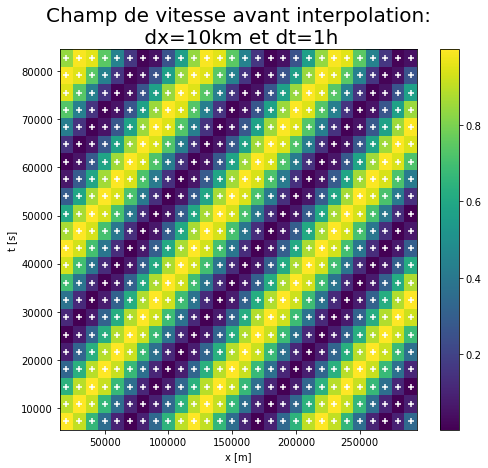

In [65]:
#Creation of the velocity field to interpolate
t2=np.arange(2*t_step,t_e,t_step)
x2=np.arange(2*x_step,x_e,x_step)
len_t2=len(t2)
len_x2=len(x2)
VF2=np.zeros((len_t2, len_x2))
for i in range(len_t2):
    for j in range (len_x2):
        VF2[i,j]=analytical_velocity_advected(t2[i], x2[j], um, uw, w, k)
vf2= xr.DataArray(data=VF2, dims=["t", "x"], coords=dict(t=(["t"], t2),x=(["x"], x2)))

plt.figure(figsize=(8,7))
vf2.plot()
for i in t2:
    plt.scatter(x2, i*np.ones_like(x2), marker="+", facecolors='w')
plt.title('Champ de vitesse avant interpolation:\n dx=10km et dt=1h', fontsize=20)
plt.xlabel('x [m]')
plt.ylabel('t [s]')

Text(0.5, 1.0, 'Champ après interpolation bilinéaire')

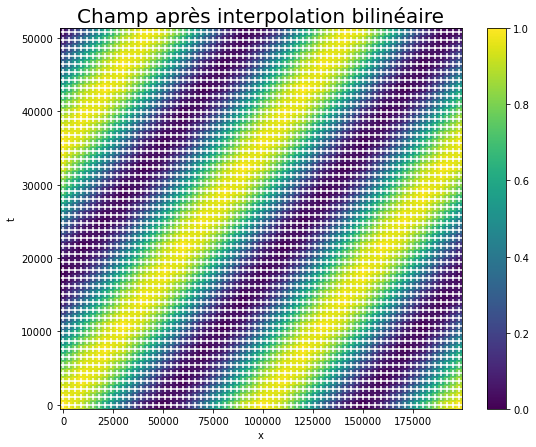

In [55]:
plt.figure(figsize=(9,7))
v_inter.plot()
for i in t_inter:
    plt.scatter(x_inter, i*np.ones_like(x_inter), marker="+", facecolors='w')
plt.title('Champ après interpolation bilinéaire', fontsize=20)

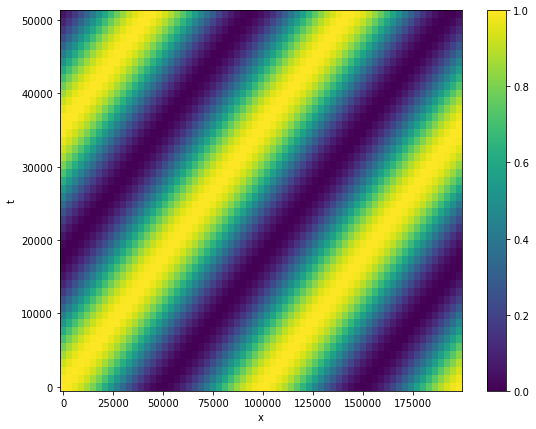

In [56]:
#Analytical velocity on the interpolated grid
plt.figure(figsize=(9,7))
len_tg=len(t_inter)
len_xg=len(x_inter)
VG=np.zeros((len_tg, len_xg))
for i in range(len_tg):
    for j in range (len_xg):
        VG[i,j]=analytical_velocity_advected(t_inter[i], x_inter[j], um, uw, w, k)
v_analytical= xr.DataArray(data=VG, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))
v_analytical.plot()

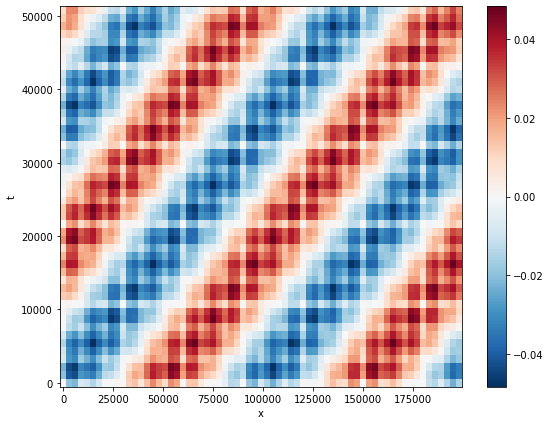

In [67]:
plt.figure(figsize=(9,7))
(v_inter-v_analytical).plot()

In [68]:
#Interpolated velocity with the x array method interp()
v_xr=vf.interp(t=t_inter, x=x_inter)

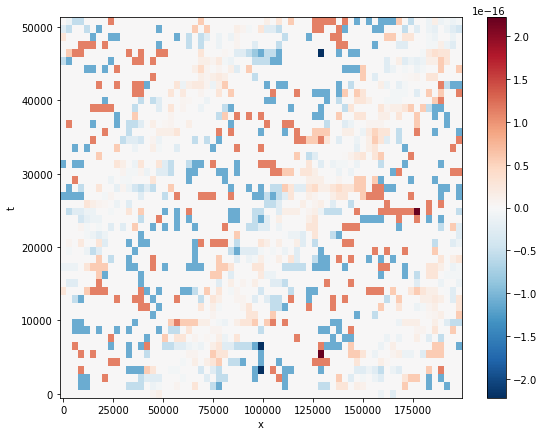

In [69]:
plt.figure(figsize=(9,7))
(v_inter-v_xr).plot()

# Lagrange interpolation

In [6]:
def lagrange_int(p_liste,ts,VF,x,t,t_step,x_step):
    v=[]
    it1 = np.searchsorted(t,ts, side='right')-1
    it=[it1+o for o in [-1,0,1,2]]

    #print(it1,it2)
    if it1+1>=len(t) or it1==0:
        print('t out of velocity flield :'+ str(ts))
        return np.zeros_like(p_liste)
    for p in p_liste:
        ip1 = np.searchsorted(x,p, side='right')-1
        if ip1+1>=len(x) or ip1==0:
            print('x out of velocity field')
            v.append(0)
        else:
            ip=[ip1+o for o in [-1,0,1,2]]
            v_sum=0
            for i in range(4):
                for j in range(4):
                    prod1=1
                    prod2=1
                    prod3=1
                    prod4=1
                    for r in range(4):
                        if r!=i:
                            prod1*=p-x[ip[r]]
                            prod2*=x[ip[i]]-x[ip[r]]
                        if r!=j:
                            prod3*=ts-t[it[r]]
                            prod4*=t[it[j]]-t[it[r]]
                    v_sum+=VF[it[j], ip[i]]*(prod1*prod3)/(prod2*prod4)
            v.append(v_sum)
    return np.array(v)


In [59]:
#Interpolated velocity field

t_inter=np.arange(t_i+t_step,0.6*d2s,t_step*0.3)
x_inter=np.arange(x_i+x_step,2*L,x_step*0.3)

V_inter=[]
for tp in t_inter:
    V_inter.append(lagrange_int(x_inter,tp,VF,x,t, t_step, x_step))

vf= xr.DataArray(data=VF, dims=["t", "x"], coords=dict(t=(["t"], t),x=(["x"], x)))
v_inter= xr.DataArray(data=V_inter, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))



Text(0.5, 1.0, 'Champ après interpolation de Lagrange')

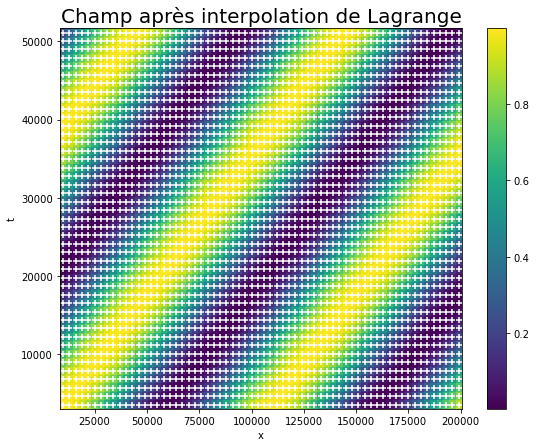

In [60]:
plt.figure(figsize=(9,7))
v_inter.plot()
for i in t_inter:
    plt.scatter(x_inter, i*np.ones_like(x_inter), marker="+", facecolors='w')
plt.title('Champ après interpolation de Lagrange', fontsize=20)

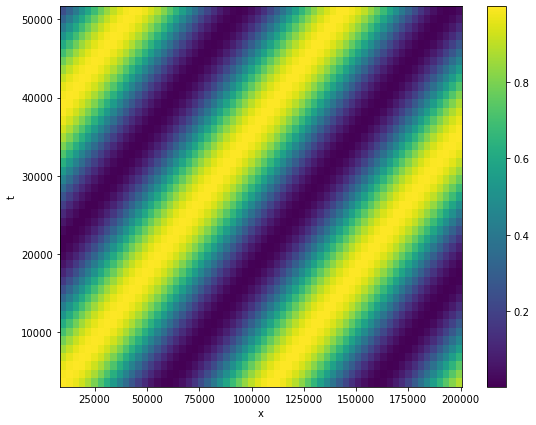

In [61]:
#Analytical velocity on the interpolated grid
plt.figure(figsize=(9,7))
len_tg=len(t_inter)
len_xg=len(x_inter)
VG=np.zeros((len_tg, len_xg))
for i in range(len_tg):
    for j in range (len_xg):
        VG[i,j]=analytical_velocity_advected(t_inter[i], x_inter[j], um, uw, w, k)
v_analytical= xr.DataArray(data=VG, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))
v_analytical.plot()

Text(0.5, 1.0, 'Interpolation de Lagrange - Solution analytique')

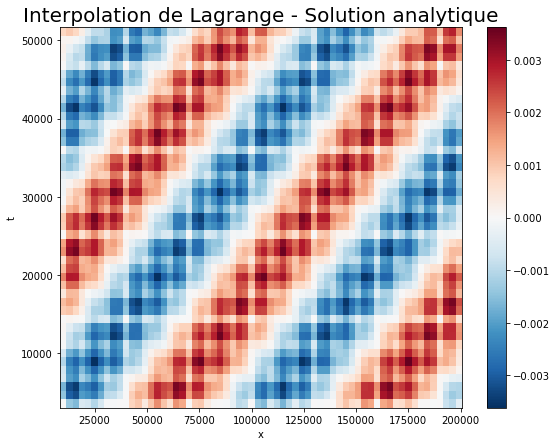

In [62]:
plt.figure(figsize=(9,7))
(v_inter-v_analytical).plot()
plt.title('Interpolation de Lagrange - Solution analytique', fontsize=20)

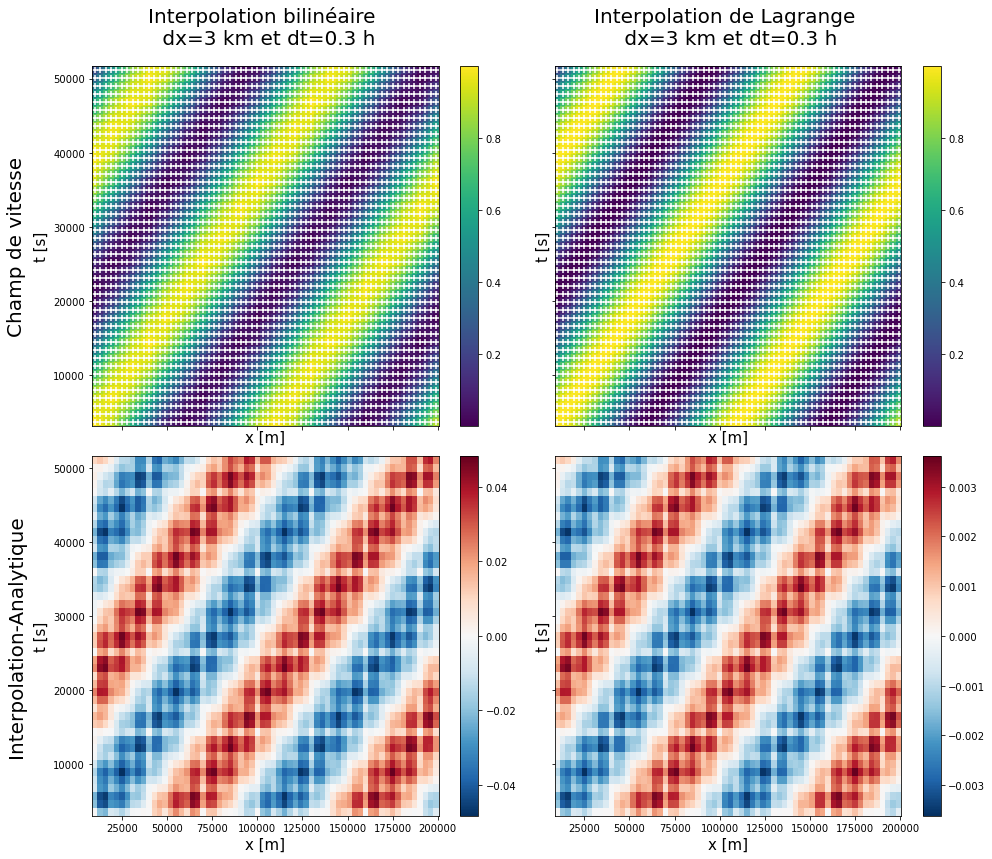

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,12), sharey='all', sharex='all')

t_inter=np.arange(t_step,0.6*d2s,t_step*0.3)
x_inter=np.arange(x_step,2*L,x_step*0.3)

V_inter=[]
for tp in t_inter:
    V_inter.append(bilinear_int(x_inter,tp,VF,x,t, t_step, x_step))

vf= xr.DataArray(data=VF, dims=["t", "x"], coords=dict(t=(["t"], t),x=(["x"], x)))
v_inter= xr.DataArray(data=V_inter, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))
len_tg=len(t_inter)
len_xg=len(x_inter)
VG=np.zeros((len_tg, len_xg))
for i in range(len_tg):
    for j in range (len_xg):
        VG[i,j]=analytical_velocity_advected(t_inter[i], x_inter[j], um, uw, w, k)
v_analytical= xr.DataArray(data=VG, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))


v_inter.plot(ax=axes[0,0])
for i in t_inter:
    axes[0,0].scatter(x_inter, i*np.ones_like(x_inter), marker="+", facecolors='w')
(v_inter-v_analytical).plot(ax=axes[1,0])



V_inter=[]
for tp in t_inter:
    V_inter.append(lagrange_int(x_inter,tp,VF,x,t, t_step, x_step))
vf= xr.DataArray(data=VF, dims=["t", "x"], coords=dict(t=(["t"], t),x=(["x"], x)))
v_inter= xr.DataArray(data=V_inter, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))
len_tg=len(t_inter)
len_xg=len(x_inter)
VG=np.zeros((len_tg, len_xg))
for i in range(len_tg):
    for j in range (len_xg):
        VG[i,j]=analytical_velocity_advected(t_inter[i], x_inter[j], um, uw, w, k)
v_analytical= xr.DataArray(data=VG, dims=["t", "x"], coords=dict(t=(["t"], t_inter),x=(["x"], x_inter)))


v_inter.plot(ax=axes[0,1])
for i in t_inter:
    axes[0,1].scatter(x_inter, i*np.ones_like(x_inter), marker="+", facecolors='w')
(v_inter-v_analytical).plot(ax=axes[1,1])


axes[0,0].annotate('Interpolation bilinéaire \n dx=3 km et dt=0.3 h', xy=(0.5, 1.05), xytext=(0, 4),xycoords='axes fraction', textcoords='offset points',size='large', ha='center', va='baseline', fontsize=20)
axes[0,1].annotate('Interpolation de Lagrange \n dx=3 km et dt=0.3 h', xy=(0.5, 1.05), xytext=(0, 4),xycoords='axes fraction', textcoords='offset points',size='large', ha='center', va='baseline',fontsize=20)
axes[0,0].annotate('Champ de vitesse', xy=(0, 0.5), xytext=(-axes[0,0].yaxis.labelpad - 4, 0), xycoords=axes[0,0].yaxis.label, textcoords='offset points',size='large', ha='right', va='center', rotation='vertical',fontsize=20)
axes[1,0].annotate('Interpolation-Analytique', xy=(0, 0.5), xytext=(-axes[1,0].yaxis.labelpad - 4, 0), xycoords=axes[1,0].yaxis.label, textcoords='offset points',size='large', ha='right', va='center', rotation='vertical',fontsize=20)

for i in range (2):
    for j in range(2):
        axes[i,j].set_xlabel('x [m]', fontsize=15)
        axes[i,j].set_ylabel('t [s]',fontsize=15)

plt.tight_layout()#left, bottom, right, top (default is 0,0,1,1)
plt.draw()
